In [1]:
import struct
import numpy as np
import intvalpy as ip
from functools import cmp_to_key
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def read_bin_file_with_numpy(file_path):
    with open(file_path, 'rb') as f:
        header_data = f.read(256)
        side, mode, frame_count = struct.unpack('<BBH', header_data[:4])

        frames = []
        point_dtype = np.dtype('<8H')

        for _ in range(frame_count):
            frame_header_data = f.read(16)
            stop_point, timestamp = struct.unpack('<HL', frame_header_data[:6])
            frame_data = np.frombuffer(f.read(1024 * 16), dtype=point_dtype)
            frames.append(frame_data)

        return np.array(frames)

def convert_to_voltage(data):
    return data / 16384.0 - 0.5


In [3]:
def are_intersected(x, y):
    sup = y.a if x.a < y.a else x.a
    inf = x.b if x.b < y.b else y.b
    return sup - inf <= 1e-15


def are_adjusted_to_each_other(x, y):
    return x.b == y.a or y.b == x.a


def merge_intervals(x, y):
    return ip.Interval(min(x.a, y.a), max(x.b, y.b))

In [4]:
def mode(x):
    if len(x) == 0:
        return []

    edges = set()
    for x_i in x:
        edges.add(x_i.a)
        edges.add(x_i.b)
    edges = sorted(list(edges))

    z = []
    for index, a in enumerate(edges):
        b = a if index == len(edges) - 1 else edges[index + 1]
        z.append(ip.Interval(a, b))

    mu = []
    for z_i in z:
        mu_i = 0
        for x_i in x:
            if z_i in x_i:
                mu_i += 1
        mu.append(mu_i)

    max_mu = max(mu)
    K = [index for index, element in enumerate(mu) if element == max_mu]

    m = [z[k] for k in K]
    merged_m = []

    current_interval = m[0]

    for next_interval in m[1:]:
        if are_intersected(current_interval, next_interval) or are_adjusted_to_each_other(current_interval,
                                                                                          next_interval):
            current_interval = merge_intervals(current_interval, next_interval)
        else:
            merged_m.append(current_interval)
            current_interval = next_interval

    merged_m.append(current_interval)

    if len(merged_m) == 1:
        return merged_m[0]

    # return merged_m
    return ip.Interval(min([inter.a for inter in merged_m]), max([inter.b for inter in merged_m]))

In [5]:
def med_k(x):
    starts = [float(interval.a) for interval in x]
    ends = [float(interval.b) for interval in x]
    return ip.Interval(np.median(starts), np.median(ends))


def med_p(x):
    x = sorted(x, key=cmp_to_key(lambda x, y: (x.a + x.b) / 2 - (y.a + y.b) / 2))
    mid = len(x) // 2

    if len(x) % 2 == 0:
        return (x[mid - 1] + x[mid]) / 2

    return x[mid]

In [6]:
def jaccard_sequence_index(x, y):
    results = []

    for x_i, y_i in zip(x, y):
        result = (min(x_i.b, y_i.b) - max(x_i.a, y_i.a)) / (max(x_i.b, y_i.b) - min(x_i.a, y_i.a))
        results.append(result)

    return np.array(results)


def multiinterval_to_outer(x: list[ip.Interval]):
    return ip.Interval(min(item.a for item in x), max(item.b for item in x))


# def jaccard_index(x, y):
#     if (type(x) is list):
#         x = multiinterval_to_outer(x)
#     if (type(y) is list):
#         y = multiinterval_to_outer(y)
#     return (min(x.b, y.b) - max(x.a, y.a)) / (max(x.b, y.b) - min(x.a, y.a))

def jaccard_index(x, y):
    return (min(x.b, y.b) - max(x.a, y.a)) / (max(x.b, y.b) - min(x.a, y.a))

In [7]:
def scalar_to_interval(x, rad):
    return ip.Interval(x - rad, x + rad)


def med(x):
    return float((x.a + x.b) / 2)

In [8]:
scalar_to_interval_vec = np.vectorize(scalar_to_interval)
x_data = read_bin_file_with_numpy('-0.205_lvl_side_a_fast_data.bin')
y_data = read_bin_file_with_numpy('0.225_lvl_side_a_fast_data.bin')

x_voltage = convert_to_voltage(x_data)
y_voltage = convert_to_voltage(y_data)

In [9]:
print(x_voltage.shape)
x_voltage = np.transpose(x_voltage, axes=(2,1,0))
y_voltage = np.transpose(y_voltage, axes=(2,1,0))
print(x_voltage.shape)
# x_voltage = x_voltage.flatten()
# y_voltage = y_voltage.flatten()

(100, 1024, 8)
(8, 1024, 100)


Text(0.5, 1.0, 'Экземпляр распределения значений X')

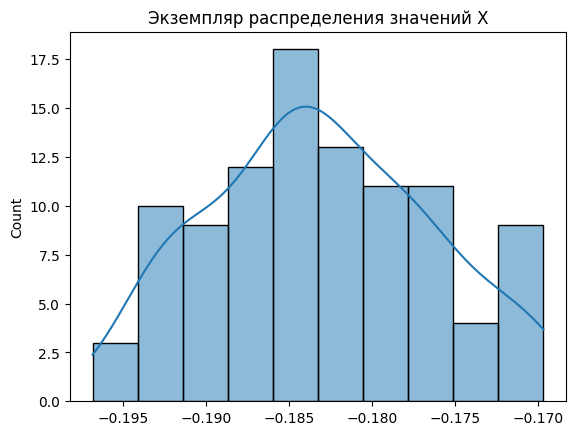

In [10]:
# plt.title('Экземпляр распределения значений X')
sns.histplot(x_voltage[0,0,:], bins=10, kde=True).set_title('Экземпляр распределения значений X')
# plt.hist(x_voltage[0,0,:], )

Text(0.5, 1.0, 'Экземпляр распределения значений Y')

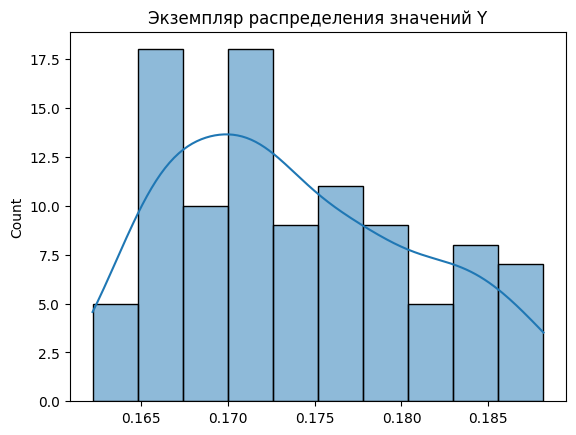

In [11]:
# plt.title('Экземпляр распределения значений Y')
# plt.hist(y_voltage[0,0,:], )
sns.histplot(y_voltage[0,0,:], bins=10, kde=True).set_title('Экземпляр распределения значений Y')

In [12]:
x_voltage = np.mean(x_voltage, axis = 2)
y_voltage = np.mean(y_voltage, axis = 2)


Text(0.5, 1.0, 'Усредненные данные по Y')

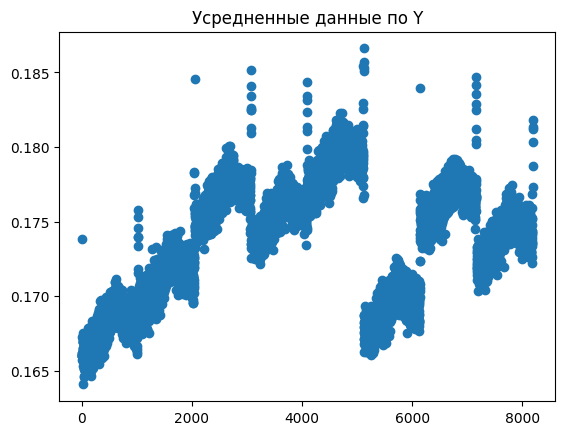

In [13]:
plt.scatter(list(range(1, y_voltage.flatten().shape[0]  + 1)), y_voltage.flatten())
plt.title('Усредненные данные по Y')

Text(0.5, 1.0, 'Усредненные данные по X')

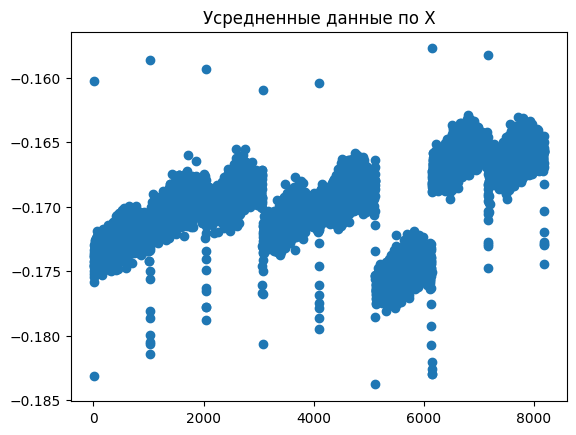

In [14]:
plt.scatter(list(range(1, x_voltage.flatten().shape[0]  + 1)), x_voltage.flatten())
plt.title('Усредненные данные по X')

In [15]:
x_voltage_all = x_voltage
y_voltage_all = y_voltage

In [97]:
selected_channel = 4
# 2, 4, 6
x_voltage = x_voltage_all[selected_channel].flatten()
y_voltage = y_voltage_all[selected_channel].flatten()

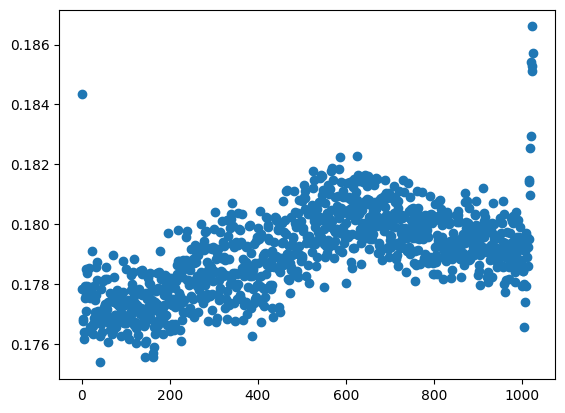

In [98]:
# plt.figure(figsize=(12, 12))
for i in range(4):
    pass
plt.scatter(list(range(1, y_voltage.shape[0]  + 1)), y_voltage)

Text(0.5, 1.0, 'Пары (x, y) до предобработки')

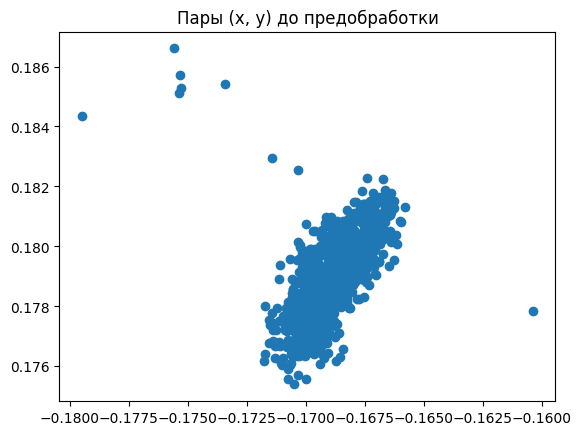

In [99]:
plt.scatter(x_voltage, y_voltage)
plt.title('Пары (x, y) до предобработки')

Text(0.5, 1.0, 'Распределения по X')

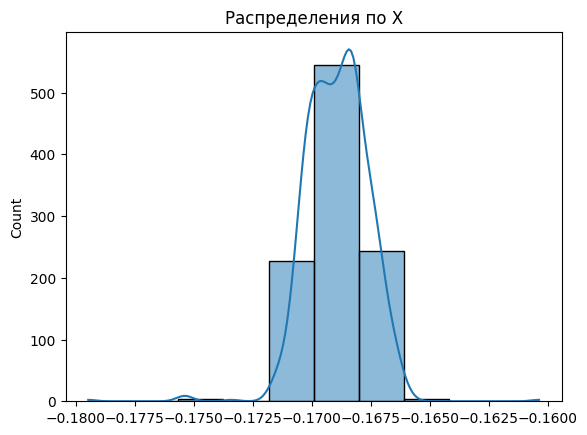

In [100]:
# plt.hist(x_voltage)
sns.histplot(x_voltage, bins=10, kde=True).set_title('Распределения по X')

Text(0.5, 1.0, 'Распределения по Y')

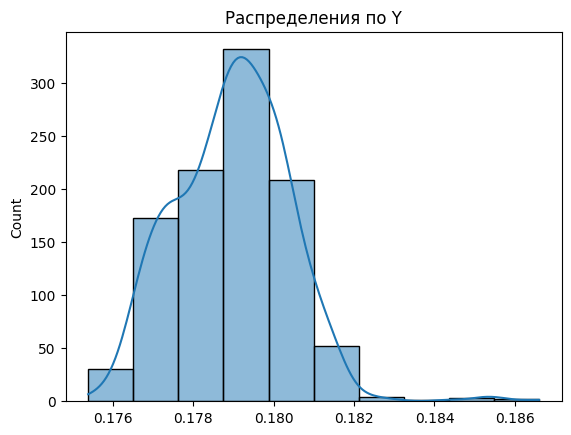

In [101]:
# plt.hist(x_voltage)
sns.histplot(y_voltage, bins=10, kde=True).set_title('Распределения по Y')

In [102]:
z_scores_x = np.abs((x_voltage - np.mean(x_voltage)) / np.std(x_voltage))
z_scores_y = np.abs((y_voltage - np.mean(y_voltage)) / np.std(y_voltage))

threshold = 3

filtered_indices = (z_scores_x < threshold) & (z_scores_y < threshold)
x_voltage = x_voltage[filtered_indices]
y_voltage = y_voltage[filtered_indices]

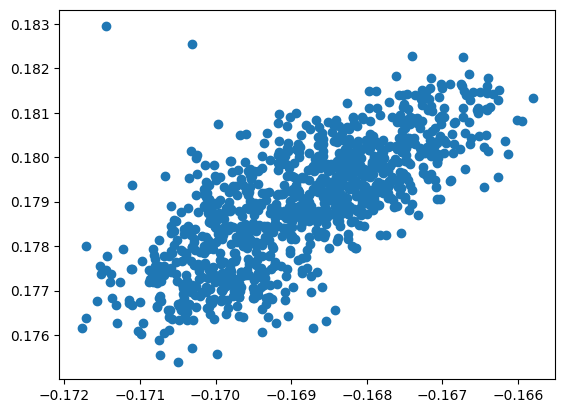

In [103]:
plt.scatter(x_voltage, y_voltage)

In [104]:
N = -14
rad = 2 ** N

x_voltage_int = scalar_to_interval_vec(x_voltage, rad)
y_voltage_int = scalar_to_interval_vec(y_voltage, rad)

In [105]:
x_voltage_int_flatten = x_voltage_int.flatten()
y_voltage_int_flatten = y_voltage_int.flatten()

## a + X = Y

In [106]:
a_bounds = [min(y_voltage_int_flatten, key=lambda x: med(x)) - max(x_voltage_int_flatten, key=lambda x: med(x)),
           max(y_voltage_int_flatten, key=lambda x: med(x)) - min(x_voltage_int_flatten, key=lambda x: med(x))]
print(a_bounds)
a_bounds.sort()
a_bounds = [med(interval) for interval in a_bounds]
print(a_bounds)

['[0.341066, 0.34131]', '[0.354583, 0.354827]']
[0.341187744140625, 0.35470458984375]


In [107]:
iters = 70

a = np.linspace(a_bounds[0], a_bounds[1], iters)
print(f"step: {np.abs(a_bounds[1] - a_bounds[0]) / iters}")

print(x_voltage_int_flatten.shape)
print(y_voltage_int_flatten.shape)
unprocessed_data = []
def estimate(a_val):
    # vec = np.array(jaccard_sequence_index(x_voltage_int_flatten + a_val, y_voltage_int_flatten))
    # vec += 1 # [-1,1] -> [0,2]
    # vec /= 2 # [0,2] -> [0,1]
    # return np.linalg.norm(vec)
    return np.mean(jaccard_sequence_index(x_voltage_int_flatten + a_val, y_voltage_int_flatten))
vec_estimate = np.vectorize(estimate)

data = vec_estimate(a)

step: 0.0001930977957589278
(1017,)
(1017,)


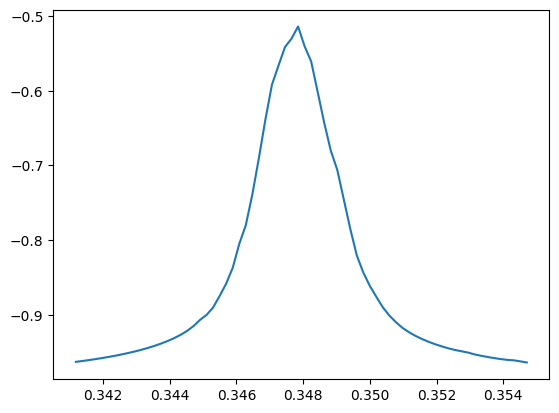

In [108]:
plt.plot(a, data)

In [109]:
print(np.argmax(data))
print(a[np.argmax(data)])

34
0.34784821883491845


In [110]:
def estimate_mod(a_val):
    return jaccard_index(mode(x_voltage_int_flatten + a_val), mode(y_voltage_int_flatten))
def estimate_med_p(a_val):
    return jaccard_index(med_p(x_voltage_int_flatten + a_val), med_p(y_voltage_int_flatten))
def estimate_med_k(a_val):
    return jaccard_index(med_k(x_voltage_int_flatten + a_val), med_k(y_voltage_int_flatten))

In [111]:
vec_estimate_mod = np.vectorize(estimate_mod)
vec_estimate_med_p = np.vectorize(estimate_med_p)
vec_estimate_med_k = np.vectorize(estimate_med_k)

In [112]:
data_med_p = vec_estimate_med_p(a)
data_med_k = vec_estimate_med_k(a)

In [113]:
from scipy.interpolate import interp1d
data = np.array([float(item) for item in data])
data_med_k = np.array([float(item) for item in data_med_k])
data_med_p = np.array([float(item) for item in data_med_p])

In [114]:
def process_data(point_data, a_data, ev: str):
    max_idx = np.argmax(point_data)
    min_idx = np.argmin(point_data)
    print(f"max y: {point_data[max_idx]}")
    print(f"min y: {point_data[min_idx]}")
    print(f"a: {a_data[max_idx]}")
    f1 = interp1d(np.array(point_data[0:max_idx + 1]), np.array(a_data[0:max_idx + 1]), kind = 'linear')
    f2 = interp1d(np.array(point_data[max_idx:]), np.array(a_data[max_idx:]), kind = 'linear')
    print(f"[{a_data[max_idx] - step}, {a_data[max_idx] + step}]")
    plt.plot(a_data, point_data)
    plt.plot(a_data[max_idx], point_data[max_idx], 'rx')
    internal_dot = (3 * point_data[max_idx] + point_data[min_idx])/ 4
    print(f"internal: {internal_dot}, x=[{f1(internal_dot):.4f},{f2(internal_dot):.4f}]")
    external_dot = (point_data[max_idx] + 3 * point_data[min_idx])/ 4
    print(f"external: {external_dot}, x=[{f1(external_dot):.4f},{f2(external_dot):.4f}]")
    plt.title(f'Параметр a, оценка: {ev}')
    plt.hlines(internal_dot, f1(internal_dot), f2(internal_dot), linestyles = 'dashed', label = '0.25', colors = 'lightgreen')
    plt.hlines(external_dot, f1(external_dot), f2(external_dot), linestyles = 'dashed', label = '0.75', colors = 'pink')
    plt.legend()

max y: -0.5139947510735249
min y: -0.9640000095814537
a: 0.34784821883491845
internal: -0.6264960657005071, x=[0.3469,0.3486]
external: -0.8514986949544715, x=[0.3458,0.3499]


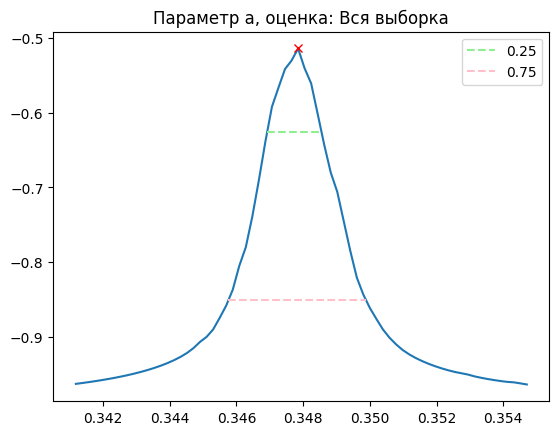

In [115]:
process_data(data, a, 'Вся выборка')

max y: 0.35833456370863037
min y: -0.9647235205926447
a: 0.34784821883491845
internal: 0.027570042633311614, x=[0.3478,0.3480]
external: -0.6339589995173258, x=[0.3473,0.3485]


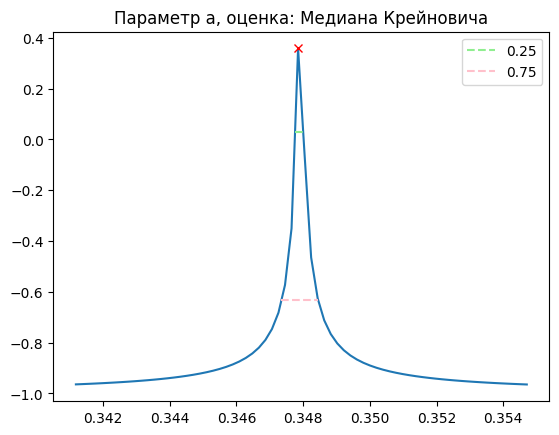

In [116]:
process_data(data_med_k, a, 'Медиана Крейновича')

max y: 0.35833456370866446
min y: -0.9647235205926448
a: 0.34784821883491845
internal: 0.027570042633337177, x=[0.3478,0.3480]
external: -0.6339589995173175, x=[0.3473,0.3485]


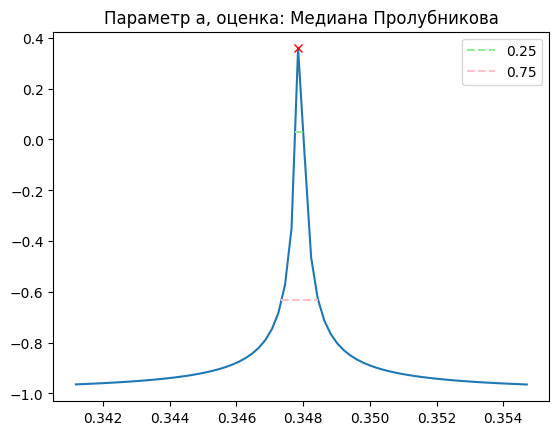

In [117]:
process_data(data_med_p, a, 'Медиана Пролубникова')

## tX = Y

In [118]:
def estimate_t(t_val):
    # vec = np.array(jaccard_sequence_index(x_voltage_int_flatten * t_val, y_voltage_int_flatten))
    # vec += 1 # [-1,1] -> [0,2]
    # vec /= 2 # [0,2] -> [0,1]
    # return np.linalg.norm(vec)
    return np.mean(jaccard_sequence_index(x_voltage_int_flatten * t_val, y_voltage_int_flatten))
vec_estimate_t = np.vectorize(estimate_t)

In [119]:
def estimate_mod_t(t_val):
    return jaccard_index(mode(x_voltage_int_flatten * t_val), mode(y_voltage_int_flatten))
def estimate_med_p_t(t_val):
    return jaccard_index(med_p(x_voltage_int_flatten * t_val), med_p(y_voltage_int_flatten))
def estimate_med_k_t(t_val):
    return jaccard_index(med_k(x_voltage_int_flatten * t_val), med_k(y_voltage_int_flatten))

In [120]:
vec_estimate_mod_t = np.vectorize(estimate_mod_t)
vec_estimate_med_p_t = np.vectorize(estimate_med_k_t)
vec_estimate_med_k_t = np.vectorize(estimate_med_p_t)

In [135]:
def process_data_t(point_data, a_data, ev: str, show = True):
    max_idx = np.argmax(point_data)
    min_idx = np.argmin(point_data)
    print(f"max y: {point_data[max_idx]}")
    print(f"min y: {point_data[min_idx]}")
    print(f"t: {a_data[max_idx]}")
    plt.plot(a_data, point_data)
    plt.plot(a_data[max_idx], point_data[max_idx], 'rx')
    plt.title(f'Параметр t, оценка: {ev}')
    if show:
        f1 = interp1d(np.array(point_data[0:max_idx + 1]), np.array(a_data[0:max_idx + 1]), kind = 'linear')
        f2 = interp1d(np.array(point_data[max_idx:]), np.array(a_data[max_idx:]), kind = 'linear')
        
        internal_dot = (3 * point_data[max_idx] + point_data[min_idx])/ 4
        print(f"internal: {internal_dot}, x=[{f1(internal_dot)},{f2(internal_dot)}]")
        external_dot = (point_data[max_idx] + 3 * point_data[min_idx])/ 4
        print(f"external: {external_dot}, x=[{f1(external_dot)},{f2(external_dot)}]")
        plt.hlines(internal_dot, f1(internal_dot), f2(internal_dot), linestyles = 'dashed', label = '0.25', colors = 'lightgreen')
        plt.hlines(external_dot, f1(external_dot), f2(external_dot), linestyles = 'dashed', label = '0.75', colors = 'pink')
        plt.legend()

# def process_data_t(point_data, a_data, show = True):
#     max_idx = np.argmax(point_data)
#     min_idx = np.argmin(point_data)
#     print(f"max y: {point_data[max_idx]}")
#     print(f"min y: {point_data[min_idx]}")
#     print(f"t: {a_data[max_idx]}")
#     plt.plot(a_data, point_data)
#     if show:
#         f1 = interp1d(np.array(point_data[0:max_idx + 1]), np.array(a_data[0:max_idx + 1]), kind = 'linear')
#         f2 = interp1d(np.array(point_data[max_idx:]), np.array(a_data[max_idx:]), kind = 'linear')
        
#         internal_dot = (3 * point_data[max_idx] + point_data[min_idx])/ 4
#         print(f"internal: {internal_dot}, x=[{f1(internal_dot)},{f2(internal_dot)}]")
#         external_dot = (point_data[max_idx] + 3 * point_data[min_idx])/ 4
#         print(f"external: {external_dot}, x=[{f1(external_dot)},{f2(external_dot)}]")
#         plt.hlines(internal_dot, f1(internal_dot), f2(internal_dot), linestyles = 'dashed', label = 'internal', colors = 'green')
#         plt.hlines(external_dot, f1(external_dot), f2(external_dot), linestyles = 'dashed', label = 'external', colors = 'red')
#         plt.legend()

## Стандартные границы

In [136]:
t_bounds = [min(y_voltage_int_flatten, key=lambda x: med(x)) / max(x_voltage_int_flatten, key=lambda x: med(x)),
           max(y_voltage_int_flatten, key=lambda x: med(x)) / min(x_voltage_int_flatten, key=lambda x: med(x))]
t_bounds.sort()
t_bounds = [med(interval) for interval in t_bounds]
# t_bounds = [-1.0663375631383605, -1.0625157441603088]
print(t_bounds)

[-1.0650560492497372, -1.0577798726695788]


In [137]:
iters = 70
t = np.linspace(t_bounds[0], t_bounds[1], iters)
print(f"step: {np.abs(t_bounds[1] - t_bounds[0]) / iters}")

step: 0.00010394537971654762


In [138]:
data_med_p_t = vec_estimate_med_p_t(t)
data_med_k_t = vec_estimate_med_k_t(t)

In [139]:
data_t = vec_estimate_t(t)
data_t = np.array([float(item) for item in data_t])

In [140]:

data_med_k_t = np.array([float(item) for item in data_med_k_t])
data_med_p_t = np.array([float(item) for item in data_med_p_t])

max y: -0.7499227201511952
min y: -0.7745211025339491
t: -1.0633688198978164


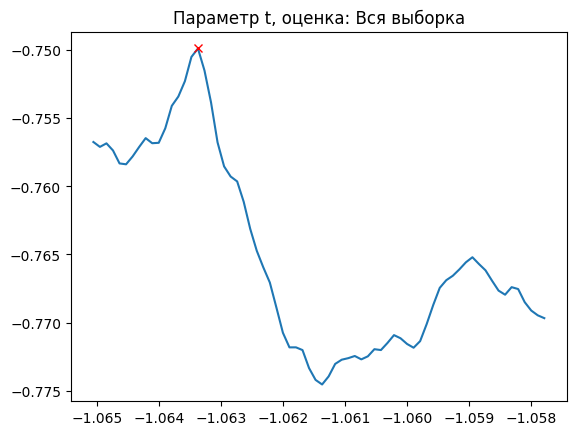

In [142]:
process_data_t(data_t, t, 'Вся выборка', False)
# process_data_t(data_t, t, False)

16
-0.7499227201511952
-1.0633688198978164
max y: 0.9202062840630699
min y: -0.7416281007556178
t: -1.0599943611939748
internal: 0.5047476878583981, x=[-1.0602730166631045,-1.0597799663730645]
external: -0.32616950455094595, x=[-1.0614923907768985,-1.0585598733182928]


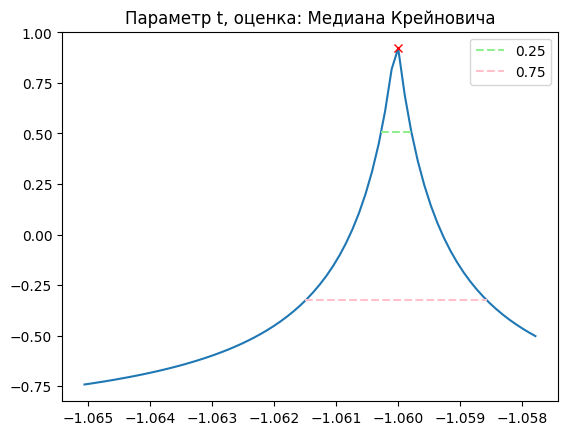

In [143]:
print(np.argmax(data_t))
print(data_t[np.argmax(data_t)])
print(t[np.argmax(data_t)])

process_data_t(data_med_k_t, t, 'Медиана Крейновича')
# process_data_t(data_med_k_t, t)

max y: 0.9202062840631743
min y: -0.7416281007556088
t: -1.0599943611939748
internal: 0.5047476878584786, x=[-1.0602730166631045,-1.0597799663730645]
external: -0.3261695045509131, x=[-1.0614923907768985,-1.0585598733182928]


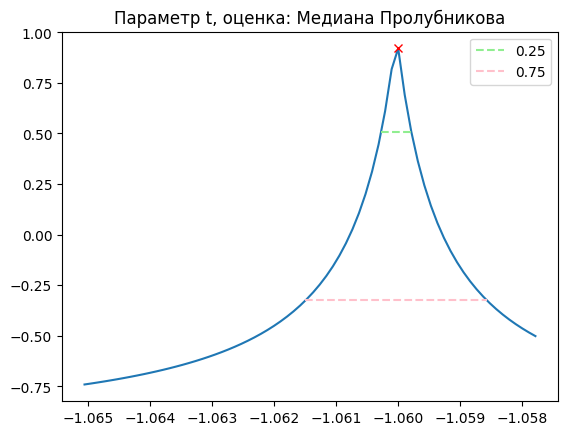

In [144]:
process_data_t(data_med_p_t, t, 'Медиана Пролубникова')

## Долгие вычисления

In [145]:
data_mod = vec_estimate_mod(a)
data_mod = np.array([float(item) for item in data_mod])

max y: 0.01935483870967742
min y: -0.948611450443847
a: 0.3474564262058424
internal: -0.22263673357870367, x=[0.3471,0.3477]
external: -0.7066198781554658, x=[0.3463,0.3485]


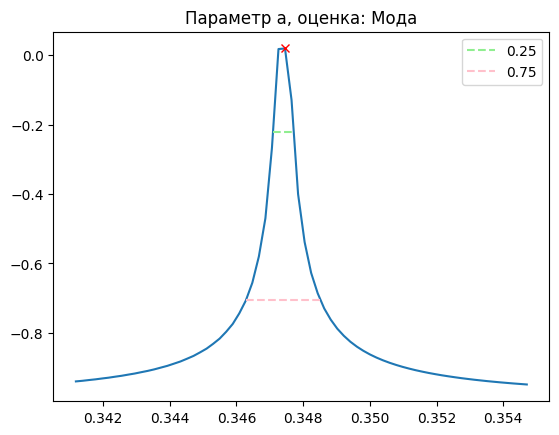

In [146]:
process_data(data_mod, a, 'Мода')

In [147]:
data_mod_t = vec_estimate_mod_t(t)
data_mod_t = np.array([float(item) for item in data_mod_t])

max y: 0.032600035350774416
min y: -0.6641672117297046
t: -1.0637906272357966


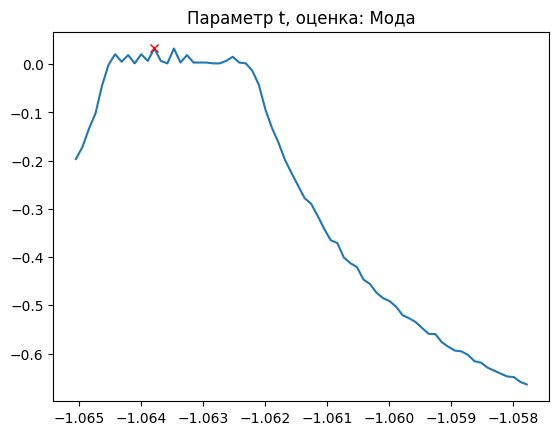

In [148]:
process_data_t(data_mod_t, t, 'Мода', False)